# Black hole imaging: solutions

In [36]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import interpolate

## Part 1: Photon deflection

Using the Scharzschild radius $r_s=2GM/c^2$ as the unit of length, the equation we have to solve is

$${d\phi\over dr} = \pm {1\over r^2}\left[{1\over b^2}-{1\over r^2}\left(1-{1\over r}\right)\right]^{-1/2}.$$

The closest approach (periastron) distance $r_c$ is determined by finding the value of $r$ for which the square bracket vanishes. 

If we start at a large distance $r_0$ and assume an impact parameter $b$, the initial angle of the photon is $\phi_0 = \sin^{-1} (b/r_0)$. We can then integrate inwards to $r_c$ and outwards again to $r_0$. 

Because the denominator vanishes at $r=r_c$, it helps numerically if we step away by a small amount and integrate to $r_c+\epsilon$ (below I take $\epsilon=10^{-10}$). 

For a positive $b$ (i.e. the trajectory starts in the upper half of the polar plot, then $d\phi/dr<0$ on the way in, and $>0$ on the way out, we use that to set the sign of the square root. (I've implemented so that $b<0$ means an orbit that starts in the lower half of the polar plot, in which case the signs are opposite). 

In [37]:
def derivs(r, y, inwards, b2):
    # parameters are b2 = b^2
    # inwards - should be +1 or -1 to set the sign of dphidr
    dphidr = -inwards * 1/(r*r * f(r,b2)**0.5)
    return [dphidr,]

def f(r, b2):
    return (1/b2)-(1/(r*r))*(1-1/r)

In [83]:
def do_one(b, inwards_only=False, rc=-1):
    # Integrates the trajectory phi(r) for impact parameter b
        
    # starting position and angle
    r0 = 1000.0
    phi0 = np.arcsin(b/r0)    # photons are travelling horizontally at large r

    # determine the periastron distance
    b2 = b*b
    # we add a small offset to rc to help the integrator
    if rc == -1:
        rc = optimize.brentq(f,0.6*b2**0.5,b2**0.5, args=(b2,))*(1+1e-10)
    
    # if the starting angle is negative then we need to change the sign of dphidr
    # this allows us to integrate paths with negative b correctly
    if phi0 < 0.0:
        fphi = -1
    else: 
        fphi = 1
    
    # integrate inwards to the periapse
    sol = solve_ivp(derivs, [r0, rc], [phi0,], atol = 1e-6,rtol=1e-6,dense_output=True,args=(fphi,b2))
    r = sol.t
    phi, = sol.y

    # and then back out again
    if  not inwards_only:
        sol = solve_ivp(derivs, [rc, r0], [phi[-1],], atol = 1e-6,rtol=1e-6,dense_output=True,args=(-fphi,b2))
        r2 = sol.t
        phi2, = sol.y
        r = np.append(r,r2)
        phi = np.append(phi,phi2)
    
    # return the combined trajectory
    return r, phi

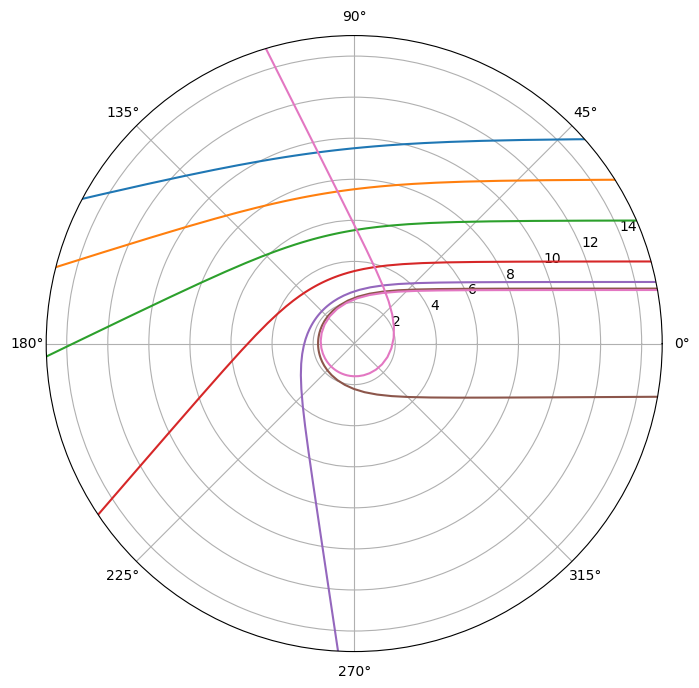

In [40]:
# Calculate trajectories that start moving parallel to the x-axis at large distance
# for different impact parameters

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))

bvals = np.array([10,8,6,4,3,2.678,2.608])

for b in bvals:
    r, phi = do_one(b)
    ax.plot(phi, r)    

ax.set_rmax(1.5*np.max(np.abs(bvals)))
ax.grid(True)


## Part 2(a): Black hole image

In [41]:
def r_disk(b, disk_angle):

    # Calculate the distance where a ray with impact parameter b intersects the disk
    # Assume the observer is at angle theta to the plane of the disk

    # do the integration and interpolate to find the r
    r, phi = do_one(b)
    rinterp = interpolate.interp1d(phi, r)
    
    if b > 0.0:
        phi_end = np.pi-disk_angle
        r_disk = rinterp(phi_end)
    else:
        phi_end = -disk_angle
        r_disk = -rinterp(phi_end)
    return r_disk


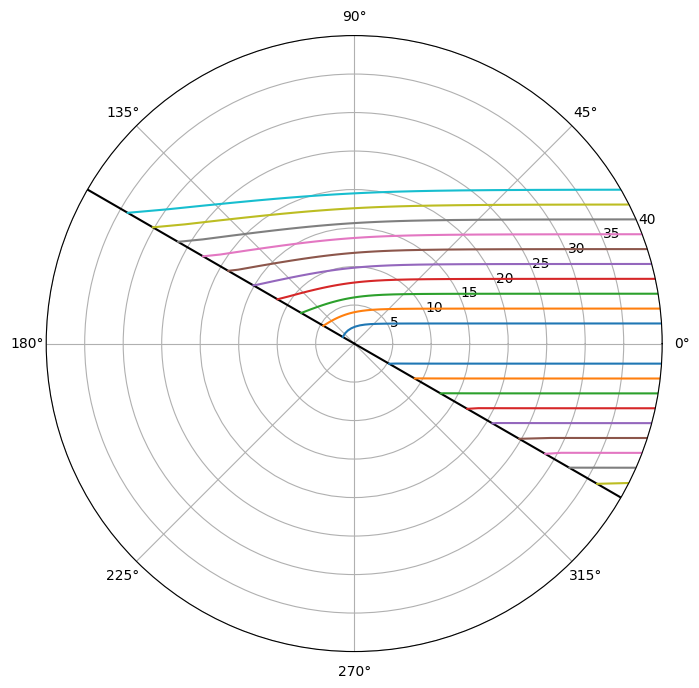

In [80]:
disk_angle = 30 # degrees
disk_angle *= np.pi/180.0 # convert to radians

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))

# consider a range of positive and negative b values
bvals = np.linspace(2.608,20,num=10)
bvals = np.append(bvals, -1*bvals)
rmax = 2*np.max(np.abs(bvals))

# plot the disk (viewed edge on) as a straight line
ax.plot((np.pi-disk_angle)*np.ones(2),[0,rmax],'k')
ax.plot((2*np.pi-disk_angle)*np.ones(2),[0,rmax],'k')

# calculate the orbit for each b, and interpolate to find the value
# of r where the angle corresponds to the disk angle
for b in bvals:

    r, phi = do_one(b)   
    
    rinterp = interpolate.interp1d(phi, r)
    
    if b > 0.0:
        phi_end = np.pi-disk_angle
        ind = phi < phi_end
        rd = rinterp(phi_end)
    else:
        phi_end = -disk_angle
        ind = phi > phi_end
        rd = rinterp(phi_end)
        
    r = np.append(r[ind],rd)
    phi = np.append(phi[ind],phi_end)

    ax.plot(phi, r)

ax.set_rmax(rmax)

ax.grid(True)

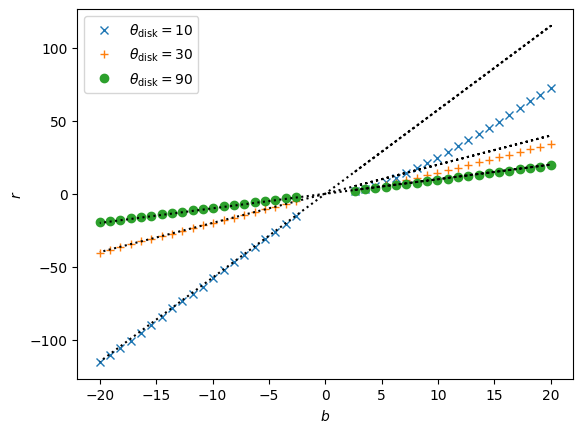

In [43]:
# Plot the relation between the impact parameter b and the disk radius r 
# for different disk angles
# The dotted lines are the Newtonian result (projected disk)

def plot_br(disk_angle, symbol_string):
    disk_angle_rad = disk_angle * np.pi/180.0
    bvec = np.linspace(2.608,20,num=20)
    bvec = np.append(bvec, -1*bvec)
    rvec = np.array([])
    for b in bvec:
        rvec = np.append(rvec, r_disk(b, disk_angle_rad))
    plt.plot(bvec, rvec, symbol_string, label=r'$\theta_\mathrm{disk}=%g$' % (disk_angle))
    plt.plot(bvec, bvec/np.sin(disk_angle_rad), 'k:')

plot_br(10,'x')
plot_br(30,'+')
plot_br(90,'o')

plt.legend()
plt.ylabel(r'$r$')
plt.xlabel(r'$b$')
plt.show()

You can compare the plot above with figures 5 and 6 in Luminet (1979). You should find good agreement with $r(b)$ along the vertical in those figures for $\theta_\mathrm{disk}=10$ and 30 degrees. Along the horizontal, you can compare with the 90 degree curve (since the disk is at 90 degrees to the photon orbital plane for photons that arrive along the horizontal axis). 

Notice that rays coming from below agree well with the Newtonian result, so the frotn pa 

## Part 2(b): Neutron star apparent size

The largest impact parameter $b$ for which the photon intersects the star is the one for which $r_c=R$. As $b$ increases from zero, the angle at which the photon hits the stellar surface becomes more and more oblique and eventually reaches 90 degrees, corresponding to the orbit with $r_c=R$. So if we calculate the function $r_c(b)$, this can be inverted to get $b(R)$, and from there the apparent area.

Before we calculate $b(R)$, first draw the photon paths to illustrate why $r_c=R$ gives the apparent size:

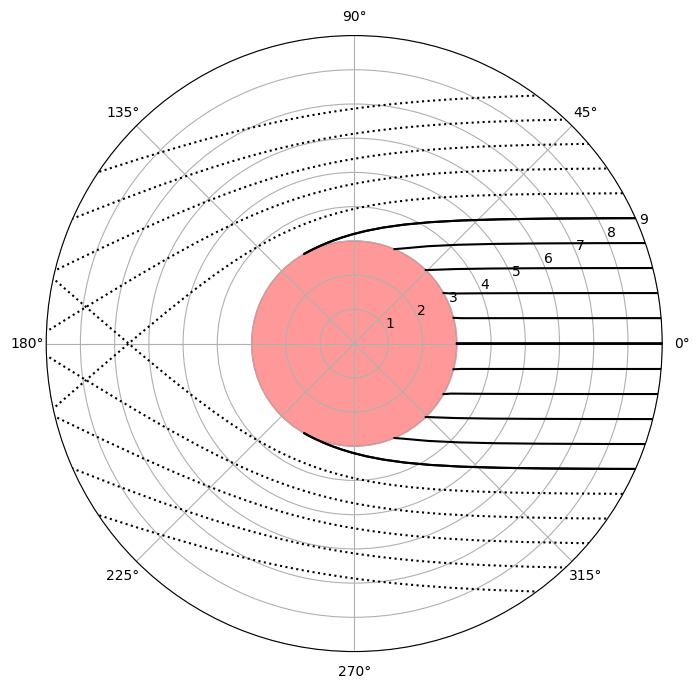

In [104]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))

# neutron star radius in units of R_S (R=3 corresponds to ~12.5km for 1.4 solar mass)
RNS = 3

# critical b which gives rc=RNS
bc = np.sqrt(RNS*RNS/(1-1/RNS))

# consider a range of positive and negative b values above and below bc
bvals = np.linspace(0.01,bc,num=6)
bvals = np.append(bvals,np.linspace(bc,2*bc,num=6))
bvals = np.append(bvals, -1*bvals)
rmax = 3*RNS

# plot the neutron star as a circle with R=3r_s  (this would be ~12.5km for 1.4 solar mass)
circle = plt.Circle((0.0, 0.0), RNS, transform=ax.transData._b, color="red", alpha=0.4)
ax.add_patch(circle)

# calculate the orbit for each b, and interpolate to find the value
# of r where the angle corresponds to the disk angle
for b in bvals:

    if abs(b) < 2.7:
        r, phi = do_one(b, inwards_only = True, rc=0.5*RNS)  
    else:
        r, phi = do_one(b, inwards_only = (abs(b)<=bc))
    phi_interp = interpolate.interp1d(r, phi)
    
    ind = np.where(r <= RNS)
    if len(ind[0])>1:
        #print(b<=bc)
        # this one goes inside the star
        ind = r>RNS
        phi_ns = phi_interp(RNS)
        r = np.append(r[ind],RNS)
        phi = np.append(phi[ind],phi_ns)
        ax.plot(phi, r, 'k')
    else:
        if abs(b)==bc:
            ax.plot(phi, r, 'k')
        else:
            ax.plot(phi, r, 'k:')

ax.set_rmax(rmax)

ax.grid(True)

Try running the plot above for different values of $R_\mathrm{NS}$ --- you will see that for large values the rays are straight lines and we see only the side of the star facing the observer, but for small values the back surface is revealed.

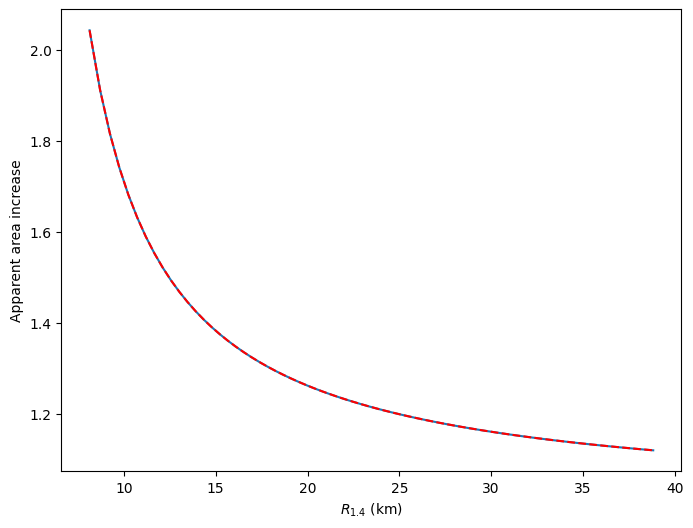

In [22]:
# Calculates the periastron distance as a function of impact parameter  r_c(b)
# --- inverting this gives the apparent size of a star of radius r_c 

bvec = np.arange(2.8,10.0,0.1)
rcvec = np.array([])

for b in bvec:
    b2 = b*b
    rc = optimize.brentq(f,0.6*b,b, args=(b2,))*(1+1e-6)
    rcvec = np.append(rcvec, rc)
    
rs = 2*2e33*6.67e-8/9e20 /1e5 * 1.4  # R_S for 1.4 M_odot star in km

plt.figure(figsize=(8,6))
plt.xlabel(r'$R_{1.4}\ (\mathrm{km})$')
plt.ylabel(r'Apparent area increase')
plt.plot(rs*rcvec, (bvec/rcvec)**2)
plt.plot(rs*rcvec, 1/(1-1/rcvec),"r--")
plt.show()


The red dashed line in the plot above (which falls right on top of the calculated curve) is the analytic prediction $$R_\infty = \left(1-{2GM\over Rc^2}\right)^{-1/2}R = (1+z)R$$ where $R_\infty$ is the apparent radius at infinity.

This scaling is consistent with the scalings for luminosity and temperature. Since energy and time both redshift by a factor $1+z$, temperature redshifts by one factor of $1+z$ and luminosity by two factors $(1+z)^2$. We can write this as $T_\infty=T_\star/(1+z)$ and $L_\infty=L_\star/(1+z)^2$, where $\star$ denotes the value at the stellar surface, and $\infty$ the value measured at infinity (e.g. temperature from the peak of the blackbody).

In order for an observer at the surface and infinity to agree that $L_\star=4\pi R^2\sigma T^4$ or $L_\infty=4\pi R_\infty^2 \sigma T_\infty^4$,  we must have $R_\infty=(1+z)R$ as we see in the above plot.